In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

# Avoiding overfitting using regularisation

[Overfitting](regression_overfitting.ipynb) can plague the maximum likelihood approach to model fitting. For example, polynomial fits to the simple 1D regression dataset showed pathalogical behaviour for $D>7$ (see plots below). In this section we will discuss how to mitigate overfitting using regularisation. 

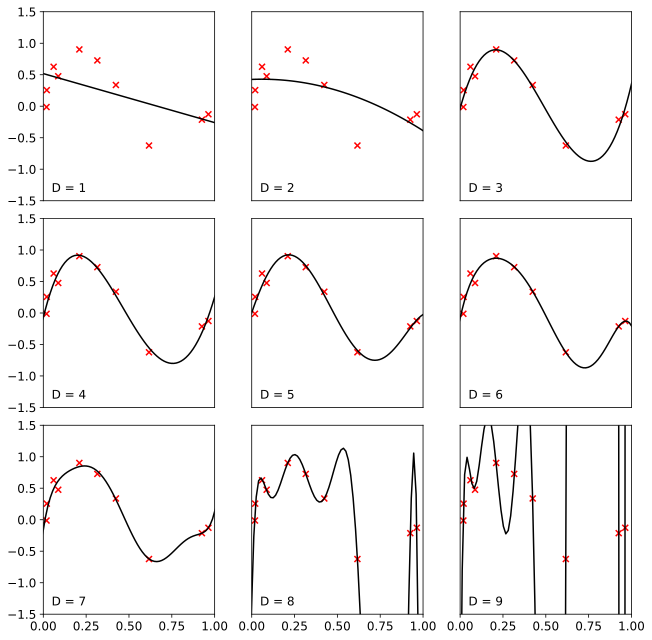

In [2]:
x_nonlin = np.load('reg_nonlin_x.npy') # load inputs from a prepared non-linear dataset
y_nonlin = np.load('reg_nonlin_y.npy') # load corresponding outputs
xs = np.linspace(-0.2, 1.2, 100) # 100 points equispaced between 0 and 1


fig = plt.figure(figsize = (9, 9)) # figure on which to plot the subfigures - you don't have to worry about this

for D in range(1, 10):

    phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_nonlin]) # training design matrix, as before
    
    w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_nonlin) # Moore-Penrose pseudoinverse
    
    phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) # design matrix of evaluation points as before
    
    ys = phi_pred.dot(w) # model predictions as before
    
    plt.subplot(3, 3, D)
    plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red') # plot 
    plt.plot(xs, ys, color = 'black')
    plt.text(0.25, -1.4, s = 'D = ' + str(D), color = 'black', fontsize = 12,
             horizontalalignment = 'right', verticalalignment = 'bottom')
    plt.xlim([0, 1])
    plt.ylim([-1.5, 1.5])
    if D % 3 is not 1:
        remove_axes('y')
    if D < 7:
        remove_axes('x')
plt.tight_layout()
plt.show()

toggle_code()

## The effect of overfitting on the weight estimates

In order to motivate the new approach, let's view effects of overfitting from another perspective by inspecting the estimated weights for each model fit:

In [3]:
toggle_code()

weights = []
for D in range(10):
    
    phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_nonlin])
    
    w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_nonlin)
    
    w = np.pad(w, (0, 10 - w.shape[0]), 'constant', constant_values = (0, 0)) # pad with 0's for unused weights
    
    weights.append(w) 

import pandas
row_names, column_names = [d for d in range(10)], ['$w_{}$'.format(d) for d in range(10)]
table = pandas.DataFrame(weights, row_names, column_names).round(2)
table.columns.name = "D"
table


D,$w_0$,$w_1$,$w_2$,$w_3$,$w_4$,$w_5$,$w_6$,$w_7$,$w_8$,$w_9$
0,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.52,-0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.43,0.11,-0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.03,9.83,-30.05,20.61,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.07,11.05,-36.72,32.37,-6.38,0.00,0.00,0.00,0.00,0.00
5,0.00,7.98,-11.57,-43.34,87.70,-40.80,0.00,0.00,0.00,0.00
6,-0.08,12.52,-64.96,193.72,-387.43,395.19,-149.15,0.00,0.00,0.00
7,-0.16,17.64,-154.12,796.59,-2322.57,3541.55,-2645.99,767.18,0.00,0.00
8,-1.25,102.89,-1982.45,17262.39,-77560.15,191624.23,-261578.47,184045.56,-51928.26,0.00
9,-4.06,375.17,-10262.16,131966.45,-901785.27,3495969.20,-7872783.54,10113533.15,-6827419.13,1870902.94


The estimated weights contain interesting structure: for low order polynomials, the weights take modest values. However, as the order of the polynomial increases the magnitudes of the high-order weight estimates increase dramatically and the signs oscillate. The large magnitude weights lead to polynomials with extreme gradients and the oscillating signs enable many zero crossings in the region of the observed data. The model is contorting to go through the observed data.

## Regularising least squares

The observation that the well-fit models have estimated weight values whose magnitudes are modest, suggests that overfitting could be mitigated by penalising large weight magnitudes. For example, a simple approach takes the sum-of-square-errors cost and adds a quadratic term $\frac{\alpha}{2}\mathbf{w}^\top\mathbf{w}$,  

\\[C_2^{(\text{reg})} = \big|\big|\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big|\big|^2 +\frac{\alpha}{2}\mathbf{w}^\top\mathbf{w}. \\]

Here $\alpha > 0$ is a constant. Now, if a weight magnitude becomes large, the quadratic term penalises the fit with $\alpha$ controlling the size of the penalty. This method discourages the weights from becoming large and is known as **regularisation**. 

Again, there is some arbitrariness in our choice of regularisation term $-$ why use $\mathbf{w}^\top\mathbf{w} = ||\mathbf{w}||^2$ and not $||\mathbf{w}||$ or in fact $||\mathbf{w}||^p$ for arbitrary $p$? 

<div class="further_box">

Regularization using different powers $p$ is known as $Lp$ regularisation. With $L1 \implies ||\mathbf{w}||$ and $~L2 \implies ||\mathbf{w}||^2$.

</div>

## Regularised least squares as maximum a posteriori fitting 

Probabilistic approaches to fitting non-linear regression place a prior distribition on the weights, $p(\mathbf{w})$. Expecting functions to typically have rather modest coefficients with small numbers of zero crossings, we place an independent Gaussian prior on the weights $p(\mathbf{w}| \sigma_{\mathbf{w}}^2) = \mathcal{N}(\mathbf{w};\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$. Here the variance $\sigma_{\mathbf{w}}^2$ controls the magnitude of the polynomials we expect to see before observing the data. 

Here are some samples from the resulting model produced by first sampling weights from the prior, $\mathbf{w}^{(m)} \sim \mathcal{N}(\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$,  and then computing the resulting function $f^{(m)}(x)=\boldsymbol{\phi}(x)^\top \mathbf{w}^{(m)}$.

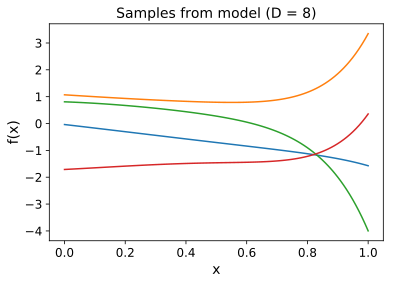

In [4]:
D = 8 # order of polynomial
var_w = 1 # a priori variance of weights
M = 5 # number of samples

xs = np.linspace(0, 1, 100) # 100 points equispaced between 0 and 1

# polynomial basis functions
phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) 

# Gaussian basis functions
# var_phi = 0.05;
# phi_pred = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in xs]) 

for m in range(1, M):
    
    # sample weights
    w = np.random.normal(0, np.power(var_w, 0.5), D+1)

    # plot function at input locations
    ys = phi_pred.dot(w) # output of the model at the points above

    plt.plot(xs, ys) # plot predictions

beautify_plot({"title":"Samples from model (D = {})".format(D), "x":"x", "y":"f(x)"})
plt.show()

toggle_code()

We can now apply probabilistic inference for the weights using Bayes' rule to find the maximum a posteriori setting of the weights given the observed data:

\begin{align}
\mathbf{w}^{\text{MAP}} & = \underset{\mathbf{w}}{\mathrm{arg\,max}} \; p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2)\\
& = \underset{\mathbf{w}}{\mathrm{arg\,min}} \;   (\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w}) - \alpha \mathbf{w}^\top \mathbf{w}  \;\; \text{where} \;\;\alpha = \frac{\sigma_y^2}{\sigma_\mathbf{w}^2}
\end{align}

<details>
<summary>Detailed derivation for the MAP weights</summary>
<div>

First we apply Bayes' rule

\begin{align}
p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) & = \frac{ p(\mathbf{w}| \sigma_{\mathbf{w}}^2) p(\mathbf{y}\mid\mathbf{X}, \mathbf{w}, \sigma_y^2) }{p(\mathbf{y}| \sigma_y^2,\sigma_{\mathbf{w}}^2)} \propto p(\mathbf{w}| \sigma_{\mathbf{w}}^2) p(\mathbf{y}\mid\mathbf{X}, \mathbf{w}, \sigma_y^2).
\end{align}

Next we substitute in for the likelihood and prior,

\begin{align}
p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) = \frac{1}{(2\pi \sigma_\mathbf{w}^2)}\text{exp}\big(-\frac{1}{2\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} \big) \times \frac{1}{(2\pi \sigma_y^2)^{N/2}}\text{exp}\big(-\frac{1}{2\sigma_y^2}(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w})\big).
 \end{align}

Now pulling the prior and likelihood terms into a single exponential we have,

\begin{align}
p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) & = \frac{1}{(2\pi \sigma_\mathbf{w}^2) (2\pi \sigma_y^2)^{N/2}}\text{exp}\big(-\frac{1}{2\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} -\frac{1}{2\sigma_y^2}(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w})\big)
\end{align}

Taking logs and combining terms that do not depend on $\mathbf{w}$ into a constant,

\begin{align}
\log p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2) & = -\frac{1}{2\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} -\frac{1}{2\sigma_y^2}(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w}) + \text{const.}.
\end{align}

Now we see that maximising $p(\mathbf{w} | \{x_n,y_n\}_{n=1}^N,\sigma_y^2,\sigma_{\mathbf{w}}^2)$ is the same as minimising $\frac{\sigma_y^2}{\sigma_\mathbf{w}^2}\mathbf{w}^\top \mathbf{w} +(\mathbf{y} - \mathbf{X}\mathbf{w})^\top (\mathbf{y} - \mathbf{X}\mathbf{w})$.

</div>
</details>

So, the simple quadratic regularisation can be interpreted as arising from a Gaussian prior on the weights and $\alpha$ is the ratio of the observation noise variance to the prior weight variance. Again the probabilistic approach reveals the hidden assumptions and makes it simple to assess their suitability. 

Let's now optimise the new cost. The use of a quadratic penalty, or equivalently a Gaussian prior on the weights, leads to an analytic solution.

$$\begin{align}\frac{\partial\mathcal{L}}{\partial \mathbf{w}} = - \boldsymbol{\Phi}^\top(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}) + \alpha\mathbf{w} = 0\\
~\\
- \boldsymbol{\Phi}^\top\mathbf{y} + \boldsymbol{\Phi}^\top\boldsymbol{\Phi}\mathbf{w} + \alpha \mathbf{I}\mathbf{w} = 0\\
~\\
\implies \boxed{\mathbf{w} = (\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha\mathbf{I})^{-1}\boldsymbol{\Phi}^\top\mathbf{y}}\\
\end{align}$$

Comparing this with the unregularized expression for $\mathbf{w}$:

$$\begin{align}
\mathbf{w} &= (\boldsymbol{\Phi}^\top\boldsymbol{\Phi})^{-1}\boldsymbol{\Phi}^\top\mathbf{y},~\text{unregularized},\\
~\\
\mathbf{w} &= (\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha \mathbf{I})^{-1}\boldsymbol{\Phi}^\top\mathbf{y},~\text{regularized},\\
\end{align}$$

we see that the only difference is the added $\alpha\mathbf{I}$ term. Since this is inside the $(\cdot)^{-1}$ matrix inverse we can intuitively see that its effect is to reduce the magnitude of the matrix elements of $(\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha\mathbf{I})^{-1}$ and hence those of $\mathbf{w}$. Consider for example the limiting case $\boldsymbol{\Phi}^\top\boldsymbol{\Phi} << \alpha\mathbf{I}$. Then $(\boldsymbol{\Phi}^\top\boldsymbol{\Phi} + \alpha\mathbf{I})^{-1} \approx \alpha^{-1}\mathbf{I}$ and increasing $\alpha$ results in smaller $\mathbf{w}$. Note that the value of $\alpha$ is arbitrarily chosen (we will later address this point). 

Let's have a look on how regularization affects the model. We'll assume small observations noise $\sigma_{y} = 0.01$ and a prior weight standard deviation of $\sigma_{\mathbf{w}} = 1$ so that $\alpha = 10^{-4}$:

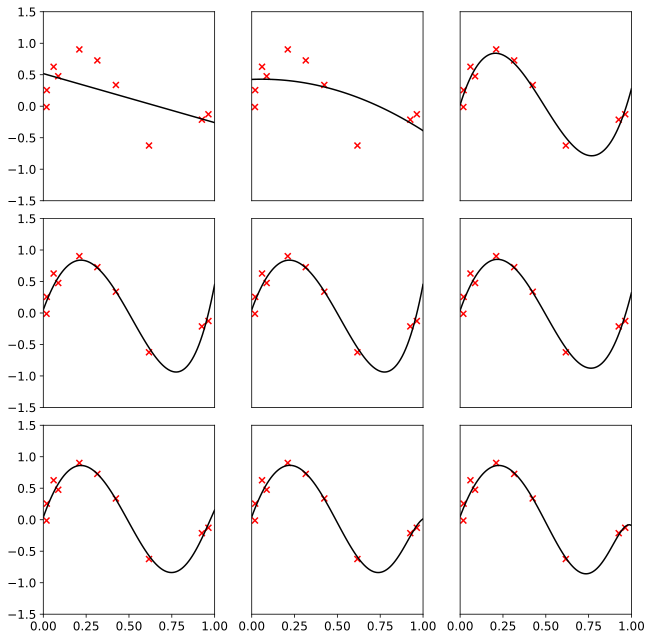

In [5]:
fig = plt.figure(figsize = (9, 9))
alpha = 10 ** -4 # arbitrarily chosen lambda

for D in range(1, 10):
    phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_nonlin])
    
    reg_term = alpha * np.eye(D + 1) # regularization term = lambda * (indentity matrix)
    
   # w = np.linalg.inv((phi.T).dot(phi) + reg_term).dot(phi.T).dot(y_nonlin) # apply regularized pseudoinverse
    w = np.linalg.solve( (phi.T).dot(phi) + reg_term , (phi.T).dot(y_nonlin) )
    
    phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) # design matrix for predictions
    
    ys = phi_pred.dot(w) # model predictions as before
    
    plt.subplot(3, 3, D)
    plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red')
    plt.plot(xs, ys, color = 'black')
    plt.xlim([0, 1])
    plt.ylim([-1.5, 1.5])
    if D % 3 is not 1:
        remove_axes('y')
    if D < 7:
        remove_axes('x')
plt.tight_layout()
plt.show()

toggle_code()

The plots show that overfitting is greatly diminished. This did involve introducing another free-parameter $\alpha$ which has to be set.  **Try altering the value of \\(\boldsymbol{\alpha}\\) to see how the fits change**. One principled way to choose \\(\alpha\\) would be to try different values for it using training/test datasets, and pick the \\(\alpha\\) which results in the best test performance. Let's also have a look at how regularisation affects the train/test errors.

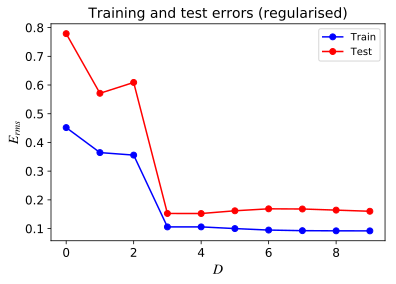

In [6]:
x_ext = np.load('reg_nonlin_x_extended.npy')
y_ext = np.load('reg_nonlin_y_extended.npy')

x_train, x_test, y_train, y_test = x_ext[:10], x_ext[10:], y_ext[:10], y_ext[10:]
alpha = 10 ** -5

train_errors, test_errors = [], []
for D in range(10):
    
    reg_term = alpha * np.eye(D + 1)
    phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_train])
    w = np.linalg.inv((phi.T).dot(phi) + reg_term).dot(phi.T).dot(y_train)
    y_trained = phi.dot(w)
    
    train_rms_error = ((y_trained - y_train) ** 2).mean() ** 0.5 #  calculating rms error of the training data
    
    phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_test])
    y_pred = phi_pred.dot(w)
    
    test_rms_error = ((y_pred - y_test) ** 2).mean() ** 0.5 # calculating rms error of the test data
    
    train_errors.append(train_rms_error)
    test_errors.append(test_rms_error)
    
plt.plot(np.arange(0, 10), train_errors, color = 'blue', marker = 'o', label = 'Train')
plt.plot(np.arange(0, 10), test_errors, color = 'red', marker = 'o', label = 'Test')
plt.gca().legend()
beautify_plot({"title":"Training and test errors (regularised)", "x":"$D$", "y": '$E_{rms}$'})
plt.show()

toggle_code()

As expected, the training error steadily decreases with $D$. The test error again reaches a minimum for $D = 3$, but unlike in the unregularised case, it doesn't explode for large $D$, because the regularization term prevents the weights from becoming large. To verify this point, let's check the values of the weights:

In [7]:
toggle_code()

weights = []
alpha = 10 ** -5

for D in range(10):
    phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_nonlin])
    reg_term = alpha * np.eye(D + 1)
    w = np.linalg.inv((phi.T).dot(phi) + reg_term).dot(phi.T).dot(y_nonlin)
    
    w = np.pad(w, (0, 10 - w.shape[0]), 'constant', constant_values = (0, 0)) # pad with 0's for unused weights
    weights.append(w) 

import pandas
row_names, column_names = [d for d in range(10)], ['$w_{}$'.format(d) for d in range(10)]
table = pandas.DataFrame(weights, row_names, column_names).round(2)
table.columns.name = "D"
table

D,$w_0$,$w_1$,$w_2$,$w_3$,$w_4$,$w_5$,$w_6$,$w_7$,$w_8$,$w_9$
0,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.52,-0.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.43,0.11,-0.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.03,9.71,-29.70,20.36,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.03,9.69,-29.58,20.15,0.12,0.00,0.00,0.00,0.00,0.00
5,-0.03,9.71,-27.33,7.47,21.62,-11.23,0.00,0.00,0.00,0.00
6,-0.02,9.07,-22.79,-0.78,16.24,12.76,-14.43,0.00,0.00,0.00
7,-0.00,8.61,-20.72,-1.09,9.45,11.75,4.11,-12.18,0.00,0.00
8,0.00,8.44,-20.44,0.75,6.62,7.89,5.54,-0.26,-8.68,0.00
9,0.01,8.41,-20.66,2.24,5.86,5.59,4.20,1.75,-1.70,-5.85


The weights are significantly decreased by regularization. **You can change $\boldsymbol{\alpha}$ to see how the weights are affected by the size of the regularization term**.

## Summary

Overfitting causes the weight estimates in a linear-in-the-parameters regression model to become extreme. Extreme settings of the weights can be discouraged by penalising their magnitude. This can be interpreted as placing a prior distribution that encodes knowledge before observing the data that the weights are likely to be small in magnitude.

In the next section we will look at [bayesian](regression_bayesian.ipynb) a bayesian approach to regression.

## Questions

1a. Look at the plot of the functions sampled from the probabilistic model, $\mathbf{w}^{(m)} \sim \mathcal{N}(\mathbf{0},\sigma_{\mathbf{w}}^2 \mathrm{I})$ and $f^{(m)}(x)=\boldsymbol{\phi}(x)^\top \mathbf{w}^{(m)}$ in the case of i) polynomial and ii) Gaussian basis functions. Alter the code to draw a large number of samples. Averaging over samples, qualitatively, how does the mean and variance of the distribution over functions depend on $x$? 

1b. Derive an analytic expression for the mean and the variance of the function, that is $\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x))$ and $\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}^2(x)) - \mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x))^2$. Compare what happens to these statistics for the two models in regions far away from the origin. 

1c. Do these results shed light on when it is appropriate to use i) polynomial basis functions and ii) Gaussian basis functions?

<details>
<summary>Answer</summary>
<div>
The mean of the distribution over functions is defined as:

$\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x)) = \int f_{\mathbf{w}}(x) p(\mathbf{w}) \mathrm{d} \mathbf{w}$.

Substituting in the definition of the function $f_{\mathbf{w}}(x) = \sum_{d=0}^D w_d \phi_d(x)$:

$\mathbb{E}_{\mathbf{w}}(f_{\mathbf{w}}(x)) = \int \sum_{d=0}^D w_d \phi_d(x) p(\mathbf{w}) \mathrm{d} \mathbf{w} =  \sum_{d=0}^D  \mathbb{E}_{\mathbf{w}} (w_d) \phi_d(x)  = 0$

So the average function is one which takes the value $0$ everywhere. The variance is defined as

$\mathbb{E}_{\mathbf{w}}(f^2_{\mathbf{w}}(x)) = \int f^2_{\mathbf{w}}(x) p(\mathbf{w}) \mathrm{d} \mathbf{w}$

where we have used the fact that the mean is zero. Substituting in the definition of the function again yields

$\mathbb{E}_{\mathbf{w}}(f^2_{\mathbf{w}}(x)) = \int \sum_{d=0}^D \sum_{d'=0}^D w_d \phi_d(x) w_{d'} \phi_{d'}(x) p(\mathbf{w}) \mathrm{d} \mathbf{w} =  \sum_{d=0}^D \mathbb{E}_{\mathbf{w}}(w^2_d) \phi^2_d(x)$

where we used the fact that the weights are independent in the prior. Therefore

$\mathbb{E}_{\mathbf{w}}(f^2_{\mathbf{w}}(x)) =  \sigma_{\mathbf{w}}^2 \sum_{d=0}^D \phi^2_d(x)$.

Notice that  in the case of polynomial regression the variance grows with the magnitude of the inputs $|x|$. That is, the functions will typically blow up once the magnitude of $x$ is large enough. For Gaussian basis functions the variance shrinks to zero away from the basis functions. Both behaviours can be problematic for extrapolation. 

</div>
</details>

2. The plot below shows a dataset which has been fit with a linear model using the MAP method. Is the fit satisfactory? How would you modify the model to improve the fit?

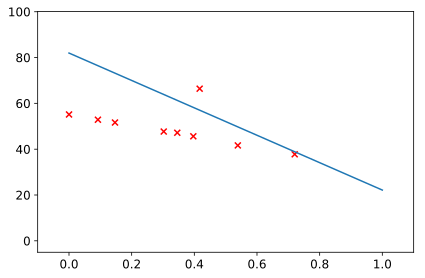

In [8]:
np.random.seed(1)

D = 1 # order of polynomial
N = 10 # number of data points per model
alpha = 10 ** -4 # arbitrarily chosen alpha

var_w = 1000 # a priori variance of weights
var_y = 0.01 # observation noise variance

### Sampling the data ###

# input locations of true function / fitted function
xs = np.linspace(0, 1, 100) # 100 points equispaced between 0 and 1

# polynomial basis functions
phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) 
 
# input locations of data
x_samp = np.random.uniform(0, 1, N) 

# polynomial basis functions
phi_samp = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_samp]) 
    
# sample weights
w = np.random.normal(0, np.power(var_w, 0.5), D+1)

# plot function at input locations
f_true = phi_pred.dot(w) # output of the model at the points above

# generate data
y_samp = phi_samp.dot(w) + np.power(var_y, 0.5)*np.random.standard_t(0.5, N)
    
### Fitting data ###

phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_samp])
reg_term = alpha * np.eye(D + 1) # regularization term = alpha * (indentity matrix)
w = np.linalg.solve( (phi.T).dot(phi) + reg_term , (phi.T).dot(y_samp) )
f_est = phi_pred.dot(w) # model predictions as before
   
    
plt.subplot(1,1,1)
#plt.plot(xs, f_true) # plot true function
plt.scatter(x_samp, y_samp, marker = 'x', color = 'red') # plot predictions
plt.plot(xs, f_est) # plot predictions

   
plt.xlim([-0.1, 1.1])
plt.ylim([-5, 100.1])
    
plt.tight_layout()
plt.show()

toggle_code()

<details>
<summary>Answer</summary>
<div>
The dataset contains an outlier which is causing the best fit line to deviate from the bulk of the data. This will likely lead to bad predictions on test data.
    
The assumption of Gaussian noise (or squared error cost) means that outliers will have significant effect. 

Instead, an alternative observation noise model should be used e.g. a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) $p(w_d | \sigma_{w}) = \frac{1}{2 \sigma_{w}}\exp(-|w_d|/\sigma_{w})$ (which results in a cost on the absolute value when using MAP or maximum-likelihood fitting) or a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) $p(w_d | \sigma_{w}) \propto (1 + \frac{v}{v-2} |w_d|^2/\sigma^2_{w})^{- (v+1)/2}$ (this was the noise used to generate the data).

These alternative observation noise models do not result in analytic fits when using maximum likelihood or MAP estimation. However optimisation based approaches can be used. This price is often worth paying as real datasets typically contain outliers and non-Gaussian noise models can make the predictions substantially more robust.

</div>
</details>